<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-LSTM%20for%204%20class%20with%20k-folds%2C%20kernel%3D0.0001%2C%20Dropout%3D0.2(90%20epochs)(01152023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for 4 class classifications with k-folds, kernel=0.0001, Dropout=0.2(100ep)**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load dataset
dataset = pd.read_csv("dataset.csv")
dataset.isnull().sum()

Event             0
Time              0
S_Node            0
Node_id           0
Rest_Energy       0
Trace_Level       0
Mac_Type_Pckt     0
Source_IP_Port    0
Des_IP_Port       0
Packet_Size       0
TTL               0
Hop_Count         0
Broadcast_ID      0
Dest_Node_Num     0
Dest_Seq_Num      0
Src_Node_ID       0
Src_Seq_Num       0
Class             0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312106 entries, 0 to 312105
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           312106 non-null  int64  
 1   Time            312106 non-null  float64
 2   S_Node          312106 non-null  int64  
 3   Node_id         312106 non-null  int64  
 4   Rest_Energy     312106 non-null  float64
 5   Trace_Level     312106 non-null  int64  
 6   Mac_Type_Pckt   312106 non-null  int64  
 7   Source_IP_Port  312106 non-null  float64
 8   Des_IP_Port     312106 non-null  float64
 9   Packet_Size     312106 non-null  int64  
 10  TTL             312106 non-null  int64  
 11  Hop_Count       312106 non-null  int64  
 12  Broadcast_ID    312106 non-null  int64  
 13  Dest_Node_Num   312106 non-null  int64  
 14  Dest_Seq_Num    312106 non-null  int64  
 15  Src_Node_ID     312106 non-null  int64  
 16  Src_Seq_Num     312106 non-null  int64  
 17  Class     

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=4)  # update to 4 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(312106, 17)
(312106, 4)


**Data Preprocessing**

In [5]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold
# Define the number of classes
num_classes = 4

# Define the number of folds
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [8]:
# Initialize lists to store evaluation metrics for each fold
accuracies = []
recalls = []
precisions = []
f1scores = []
confusion_matrices = []
classification_reports = []

In [9]:
# Iterate through the folds
for fold, (train_index, test_index) in enumerate(skf.split(X, y.argmax(axis=1))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

**Hybrid RF-LSTM for 4 class Ver.2.2**

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, train_rf_features.shape[1]))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, test_rf_features.shape[1]))

In [11]:
# Train LSTM model with RF features
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_model.fit(train_rf_features, y_train, epochs=90, batch_size=64, validation_split=0.2)

# Evaluate hybrid model on test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

#print(confusion_matrix(np.argmax(y_test, axis=1), test_rf_lstm_predictions))
#print(classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions))

# Plot training/validation loss over each epoch
#plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation/Test Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

Epoch 1/90
11829/11829 [==============================] - 92s 7ms/step - loss: 0.0261 - accuracy: 0.9950 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/90
11829/11829 [==============================] - 81s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 8.8484e-04 - val_accuracy: 1.0000
Epoch 3/90
11829/11829 [==============================] - 80s 7ms/step - loss: 8.5304e-04 - accuracy: 1.0000 - val_loss: 6.9222e-04 - val_accuracy: 1.0000
Epoch 4/90
11829/11829 [==============================] - 81s 7ms/step - loss: 7.0530e-04 - accuracy: 1.0000 - val_loss: 5.7519e-04 - val_accuracy: 1.0000
Epoch 5/90
11829/11829 [==============================] - 82s 7ms/step - loss: 6.1489e-04 - accuracy: 1.0000 - val_loss: 5.9354e-04 - val_accuracy: 1.0000
Epoch 6/90
11829/11829 [==============================] - 80s 7ms/step - loss: 5.6905e-04 - accuracy: 1.0000 - val_loss: 4.8304e-04 - val_accuracy: 1.0000
Epoch 7/90
11829/11829 [==============================] - 77s 6ms/step - loss: 5.2

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
recall = recall_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
precision = precision_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
f1score = f1_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, digits=6)

# Append metrics to lists
accuracies.append(accuracy)
recalls.append(recall)
precisions.append(precision)
f1scores.append(f1score)
confusion_matrices.append(confusion_mat)
classification_reports.append(classification_rep)

# Print metrics for each fold
print(f"\nMetrics for Fold {fold + 1}:\n")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)


Metrics for Fold 10:

Accuracy: 0.999781244055545
Recall: 0.999781244055545
Precision: 0.9997812491159127
F1-Score: 0.9997812417019166
Confusion Matrix:
 [[26283     2     0     0]
 [    3 26278     0     4]
 [    0     0 26283     2]
 [    0     9     3 26273]]
Classification Report:
               precision    recall  f1-score   support

           0   0.999886  0.999924  0.999905     26285
           1   0.999582  0.999734  0.999658     26285
           2   0.999886  0.999924  0.999905     26285
           3   0.999772  0.999543  0.999658     26285

    accuracy                       0.999781    105140
   macro avg   0.999781  0.999781  0.999781    105140
weighted avg   0.999781  0.999781  0.999781    105140



In [13]:
# Print average metrics across all folds
print("\nAverage Metrics Across Folds:\n")
print("Average Accuracy:", accuracy)
print("Average Recall:", recall)
print("Average Precision:", precision)
print("Average F1-Score:", f1score)


Average Metrics Across Folds:

Average Accuracy: 0.999781244055545
Average Recall: 0.999781244055545
Average Precision: 0.9997812491159127
Average F1-Score: 0.9997812417019166


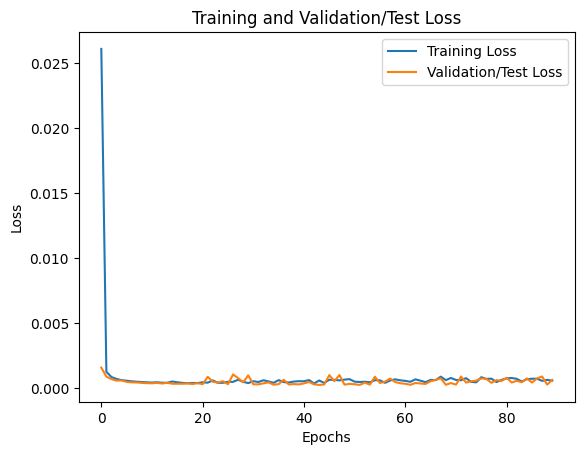

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

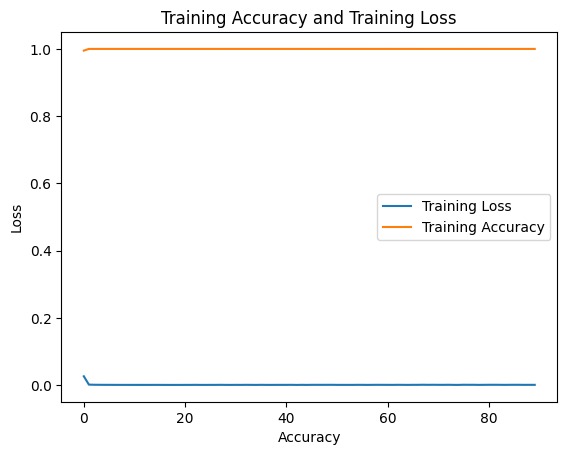

In [15]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

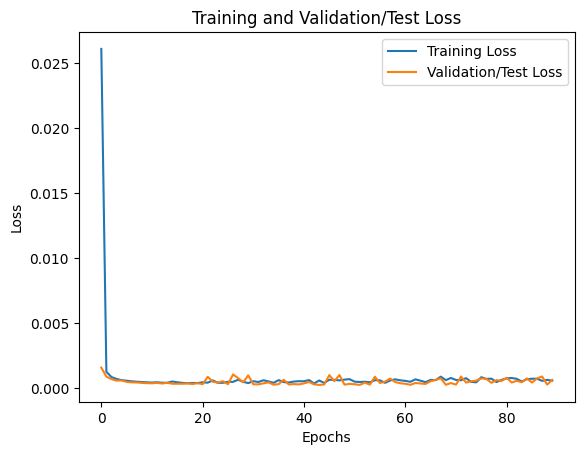

In [16]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='bone')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


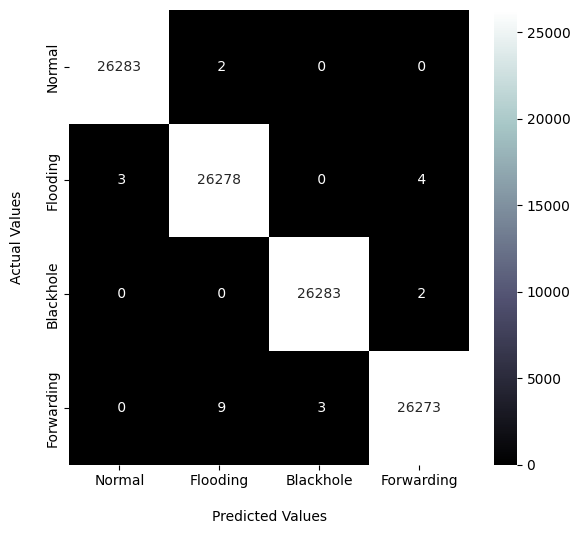

In [18]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)

In [19]:
report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid RF-LSTM Model:", detection_rates)

Detection rates of Hybrid RF-LSTM Model: {0: 0.9999239109758418, 1: 0.9997336884154461, 2: 0.9999239109758418, 3: 0.9995434658550504}


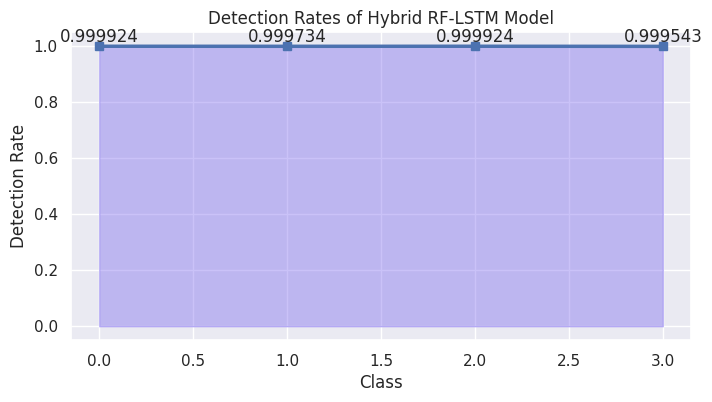

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Extract the class labels and detection rates
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the line graph with filled area and labels
plt.figure(figsize=(8, 4))
plt.plot(labels, rates, marker='s', linestyle='-', linewidth=2.5)
plt.fill_between(labels, rates, color='mediumslateblue', alpha=0.4)

# Add labels to each data point
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.6f}".format(rates[i]), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

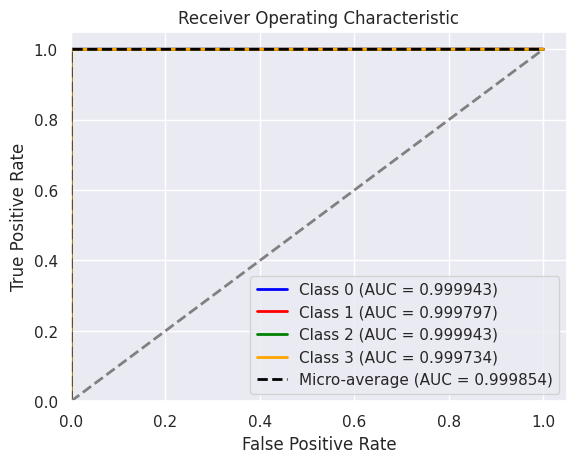

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils

# Convert y_test and test_rf_lstm_predictions to one-hot encoded format
y_test_onehot = np_utils.to_categorical(np.argmax(y_test, axis=1))
test_rf_lstm_predictions_onehot = np_utils.to_categorical(test_rf_lstm_predictions, num_classes=4)  # Convert to one-hot encoded format with 4 classes

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_lstm_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_lstm_predictions_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.6f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.6f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
##print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
##print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))

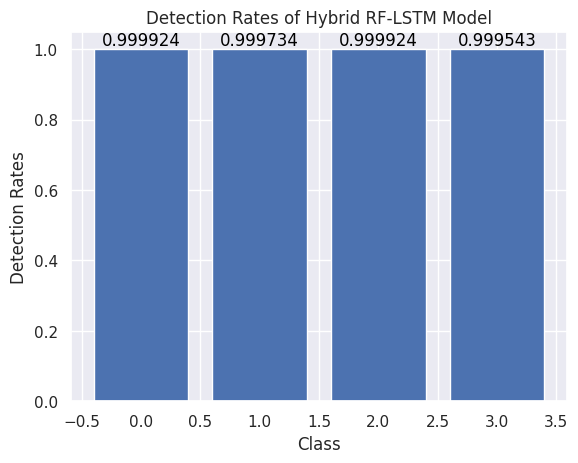

In [22]:
import matplotlib.pyplot as plt

# Extract the labels and rates from the detection rates dictionary
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the bar chart
plt.bar(labels, rates)

# Add labels and units to each bar
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.6f}".format(rates[i]), ha='center', va='bottom', color='black')

# Add axis labels and title
plt.xlabel('Class')
plt.ylabel('Detection Rates')
plt.title('Detection Rates of Hybrid RF-LSTM Model')

# Display the plot
plt.show()